In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# Scikit-Learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# PyTorch
import torch
import torch.nn as nn

# PyTorch Lightning
import pytorch_lightning as pl

# From src
from src.inference import format_predictions, calculate_metrics
from src.models import FullyConnectedNetwork
from src.model_training import TrainingLoop

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device} is available.")

cpu is available.


In [3]:
# Seed
seed = 6715
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
pl.seed_everything(seed)

Global seed set to 6715


6715

In [4]:
# Config
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 32
EPOCHS = 100 if AVAIL_GPUS else 20

In [5]:
train = torch.load("../data/train.pt")
val = torch.load("../data/val.pt")
test = torch.load("../data/test.pt")

# Training the Network

In [6]:
# Hyperparameters
input_size = next(iter(train))[0].shape[0]
output_size = next(iter(train))[1].shape[0]
hidden_size = 128
num_layers = 2
dropout_prob = 0
learning_rate = 1e-2
activation_function = 'relu'

optimizer = 'Adam'
loss_fn = nn.MSELoss()

# Build model
model = FullyConnectedNetwork(
    hidden_size = hidden_size,
    num_fcn_layers = num_layers,
    input_size = input_size,
    output_size = output_size,
    activation_fnc = activation_function,
    dropout = dropout_prob,
    device = device
    )


print(model)

In [14]:
class Model(nn.Module):

    def __init__(self, input_size):
        super().__init__()

        self.input_size = input_size
        self.activation = nn.ReLU
        
        self.flatten = nn.Flatten()
        self.input_layer = nn.Sequential(nn.Linear(self.input_size, 64), self.activation())

        self.hidden_block = nn.Sequential(
                nn.Linear(64, 128),
                self.activation(),
                nn.Linear(128, 256),
                self.activation(),
                nn.Dropout(0.2),
                nn.Linear(256, 128),
                self.activation(),
                nn.Dropout(0.2),
        )
        
        self.output_layer = nn.Linear(128, 24)

    def forward(self, x):
        x = self.flatten(x)
        x = self.input_layer(x)
        x = self.hidden_block(x)
        out = self.output_layer(x)
        return out

In [15]:
model = Model(input_size=input_size)

In [16]:
train_loop = TrainingLoop(
            model=model, 
            datasets=(train, val, test),
            learning_rate=learning_rate,
            batch_size=BATCH_SIZE,
            optimizer=optimizer,
            accelerator=device,
            train_shuffle=False,
            num_dl_workers=2
        )

In [17]:
trainer = pl.Trainer(
    accelerator=device,
    devices=1,
    min_epochs=1,
    max_epochs=EPOCHS,
    gradient_clip_val=0,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [18]:
# Run training
trainer.fit(train_loop)


  | Name  | Type  | Params
--------------------------------
0 | model | Model | 82.2 K
--------------------------------
82.2 K    Trainable params
0         Non-trainable params
82.2 K    Total params
0.329     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Inference

In [11]:
# Run predictions
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at c:\Users\nva\Documents\Teaching\external\ml_kursus\notebooks\lightning_logs\version_5\checkpoints\epoch=19-step=11040.ckpt
Loaded model weights from checkpoint at c:\Users\nva\Documents\Teaching\external\ml_kursus\notebooks\lightning_logs\version_5\checkpoints\epoch=19-step=11040.ckpt
c:\Users\nva\Documents\Teaching\external\ml_kursus\venv\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

[{}]

In [12]:
predictions, values = train_loop.predictions, train_loop.values
#predictions = [tensor.cpu() for tensor in predictions]
#values = [tensor.cpu() for tensor in values]

preds = np.concatenate(predictions, axis=0)
vals = np.concatenate(values, axis=0)

scaler = pickle.load(open('../data/scaler.pkl', 'rb'))

preds = scaler.inverse_transform(preds)
vals = scaler.inverse_transform(vals)

In [13]:
target_cols = [f'load+{h}' for h in range(1, 25)]
test_index = pd.date_range("2021-09-11 14:00:00", "2022-05-14 23:00:00", freq='h')

df_preds = pd.DataFrame(preds, columns=target_cols, index=test_index[:len(vals)])
df_vals = pd.DataFrame(vals, columns=target_cols, index=test_index[:len(vals)])

In [14]:
print('TEST PERFORMANCE')
print('RMSE:\t', mean_squared_error(df_vals, df_preds)**0.5)
print('MAE:\t', mean_absolute_error(df_vals, df_preds))
print('MAPE:\t',mean_absolute_percentage_error(df_vals, df_preds) * 100)
print('R^2:\t', r2_score(df_vals, df_preds))

TEST PERFORMANCE
RMSE:	 23.028133269438058
MAE:	 18.346853
MAPE:	 22.918565571308136
R^2:	 0.4558931746670866


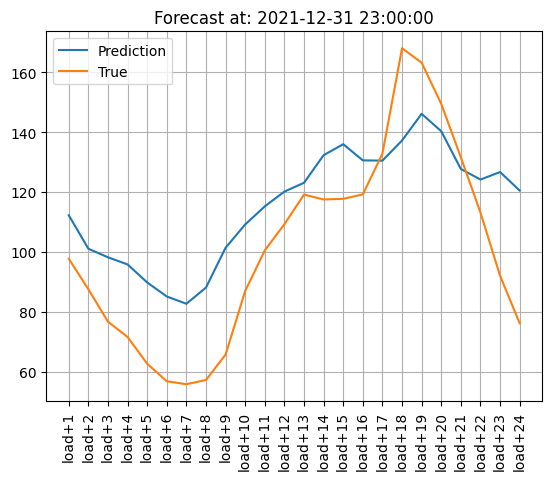

In [17]:
forecast_time = '2021-12-31 23:00:00'
plt.plot(df_preds.loc[forecast_time], label='Prediction')
plt.plot(df_vals.loc[forecast_time], label='True')
plt.legend()
plt.grid()
plt.title(f"Forecast at: {forecast_time}")
plt.xticks(rotation=90)
plt.show()